<a href="https://colab.research.google.com/github/Abertocoea/GenerativeModel/blob/main/GAN_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Abertocoea/GenerativeModel.git


Cloning into 'GenerativeModel'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [35]:
!git remote add origin https://github.com/Abertocoea/GenerativeModel.git


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



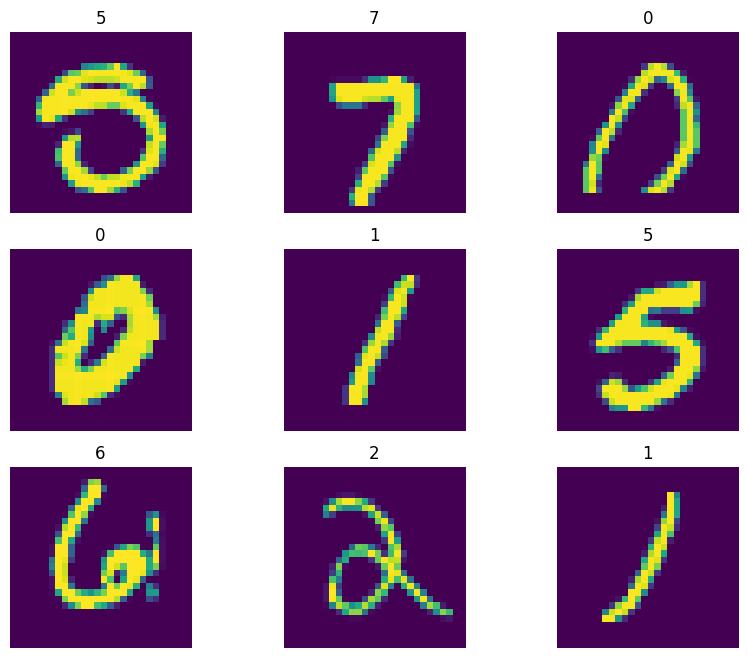

In [4]:
# plot di alcune delle immagini

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #imshow si aspetta shape (h,w,channels)
plt.show()

In [38]:
class CNN_Generator(nn.Module):
    def __init__(self, latent_dim):
        super(CNN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh() # Output normalizzato tra -1 e 1
        )

    def forward(self, x):
        return self.model(x)


In [39]:
class CNN_Discriminator(nn.Module):
    def __init__(self):
        super(CNN_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # Output tra 0 e 1
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [47]:
latent_dim = 100   # Dimensione del vettore di rumore
batch_size = 128
epochs = 20
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:

generator = CNN_Generator(latent_dim).to(device)
discriminator = CNN_Discriminator().to(device)

# Ottimizzatori
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [50]:

for epoch in range(epochs):
    for real_images,_ in dataloader: #le label non ci interessano
        # Addestramento del Discriminatore
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Per immagini reali
        outputs = discriminator(real_images)
        loss_real = criterion(outputs, real_labels)

        # Per immagini false
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        loss_fake = criterion(outputs, fake_labels)

        # Backpropagation del Discriminatore
        loss_D = loss_real + loss_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Addestramento del Generatore
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        loss_G = criterion(outputs, real_labels)

        # Backpropagation del Generatore
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"EPOCH:{epoch +1 }Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



EPOCH:0Loss D: 0.8093, Loss G: 0.8449
EPOCH:1Loss D: 0.2251, Loss G: 1.6562
EPOCH:2Loss D: 0.4994, Loss G: 1.9817
EPOCH:3Loss D: 0.2999, Loss G: 1.8007
EPOCH:4Loss D: 0.3718, Loss G: 1.8739
EPOCH:5Loss D: 0.4780, Loss G: 2.3752
EPOCH:6Loss D: 0.4818, Loss G: 0.7315
EPOCH:7Loss D: 0.4146, Loss G: 3.7737
EPOCH:8Loss D: 0.2955, Loss G: 4.3542
EPOCH:9Loss D: 0.6414, Loss G: 0.8441
EPOCH:10Loss D: 0.1731, Loss G: 2.9886
EPOCH:11Loss D: 0.2998, Loss G: 2.1422
EPOCH:12Loss D: 0.2431, Loss G: 4.0265
EPOCH:13Loss D: 0.1271, Loss G: 1.8071
EPOCH:14Loss D: 0.3435, Loss G: 2.0256
EPOCH:15Loss D: 0.3482, Loss G: 2.9373
EPOCH:16Loss D: 0.5603, Loss G: 5.6326
EPOCH:17Loss D: 0.3866, Loss G: 4.8538
EPOCH:18Loss D: 0.1320, Loss G: 3.5629
EPOCH:19Loss D: 0.8315, Loss G: 4.7011


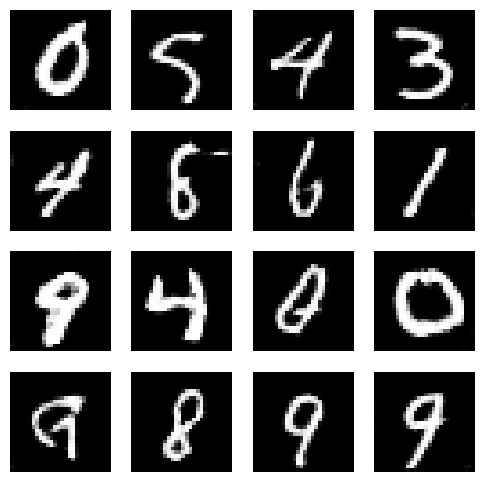

In [51]:
z = torch.randn(16, latent_dim, 1, 1)  # Reshape to (batch_size, latent_dim, 1, 1)
generator.to('cpu')  # Sposta il generatore su CPU
generated_images = generator(z).detach().numpy()

fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i*4 + j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')
plt.show()